In [1]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import matthews_corrcoef, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_validate
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE 
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

plt.rcParams['figure.figsize'] = [6, 6]

In [2]:
%cd ..

/home/belu/VS Workplace/licentiate-thesis-repo


In [3]:
import src.data.notebook_utils as utils

In [5]:
df_all = utils.read_data()
#df_all = df_all.drop(["_rxn_mixingtime2S", "_rxn_stirrateRPM", "_rxn_mixingtime1S", "_rxn_reactiontimeS", "_rxn_organic-inchikey"], axis=1)
df_all['_out_crystalscore'] = (df_all['_out_crystalscore'] == 4).astype(int)

In [6]:
df_all.columns

Index(['_feat_MolPol', '_feat_MaximalProjectionArea',
       '_feat_AromaticRingCount', '_feat_minimalprojectionsize',
       '_rxn_M_inorganic', '_rxn_M_organic', '_feat_molsurfaceareaASAp',
       '_feat_VanderWaalsSurfaceArea', '_feat_msareaASAp', '_rxn_M_acid',
       '_feat_maximalprojectionsize', '_feat_AromaticAtomCount', '_feat_ASA-',
       '_feat_msareaVDWp', '_feat_RingAtomCount', '_feat_AvgPol', '_feat_ASA',
       '_feat_HyperWienerIndex', 'Chemical Abbreviation',
       '_feat_CyclomaticNumber', '_feat_LargestRingSize',
       '_feat_LengthPerpendicularToTheMinArea', '_feat_VanderWaalsVolume',
       '_feat_ASA_P', '_feat_MaximalProjectionRadius',
       '_feat_MinimalProjectionArea', '_out_crystalscore', '_feat_ASA+',
       '_feat_WienerIndex', '_feat_ASA_H', '_feat_Refractivity',
       '_feat_BalabanIndex', '_feat_LengthPerpendicularToTheMaxArea',
       '_feat_SmallestRingSize', '_feat_CarboRingCount',
       '_feat_CarboaromaticRingCount', '_feat_molsurfaceareaVDWp'

In [7]:
df_all[['_out_crystalscore']].value_counts()

_out_crystalscore
0                    3630
dtype: int64

In [14]:
rings_feat = ['_feat_CyclomaticNumber',
 '_feat_CarboaromaticRingCount',
 '_feat_CarboRingCount',
 '_feat_LargestRingSize',
 '_feat_RingAtomCount',
 '_feat_SmallestRingSize',
 '_feat_AromaticRingCount',
 '_feat_AromaticAtomCount']
columns_arbitrary_decision = ["_feat_BalabanIndex", "_feat_VanderWaalsSurfaceArea", "_feat_VanderWaalsVolume", "_feat_ASA", "_feat_WienerIndex", "_feat_maximalprojectionsize"]
continous_feat = ['_feat_molsurfaceareaVDWp', '_feat_maximalprojectionsize', '_feat_MinimalProjectionArea', '_feat_minimalprojectionsize', '_feat_MaximalProjectionArea', '_feat_MolPol', '_feat_ASA_P', '_feat_msareaVDWp', '_feat_ASA', '_feat_ASA-', '_feat_MinimalProjectionRadius', '_feat_molsurfaceareaASAp', '_feat_LengthPerpendicularToTheMinArea', '_feat_WienerIndex', '_feat_ASA+', '_feat_MaximalProjectionRadius', '_feat_VanderWaalsSurfaceArea', '_feat_LengthPerpendicularToTheMaxArea', '_feat_VanderWaalsVolume', '_feat_BalabanIndex', '_feat_ASA_H', '_feat_HyperWienerIndex', '_feat_msareaASAp', '_feat_Refractivity', '_feat_AvgPol']
rxn_feat = ["_rxn_M_acid", "_rxn_M_organic", "_rxn_M_inorganic", "_out_crystalscore"] 


In [15]:
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

scoring_sample = {"matt": make_scorer(matthews_corrcoef), "precision": make_scorer(precision_score),
                 "recall": make_scorer(recall_score), "f1": make_scorer(f1_score)
                 }

In [16]:
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import ADASYN 

def run_smote_with(df, model):
    X = df.drop(['_out_crystalscore'], axis=1)
    y = df['_out_crystalscore']

    # define model
    ada = ADASYN(random_state=42, sampling_strategy=0.4, n_jobs = -1)
    under = RandomUnderSampler(sampling_strategy=0.5)
    adasyn = [('std', StandardScaler()), ('ada', ada), ('model', model)] 
    border_steps = [('std', StandardScaler()), ('over', BorderlineSMOTE(sampling_strategy=0.4)), ('model', model)] 
    steps_both = [('std', StandardScaler()), ('over', SMOTE(sampling_strategy=0.4)), ('under', under), ('model', model)] 
    steps = [('std', StandardScaler()), ('over', SMOTE(sampling_strategy=0.5)), ('model', model)]
    steps_no_smote = [('std', StandardScaler()), ('model', model)]
    pipeline = Pipeline(steps=steps)
    pipeline_no_smote = Pipeline(steps=steps_no_smote)
    pipeline_both = Pipeline(steps=steps_both)
    pipeline_border = Pipeline(steps=border_steps)
    pipeline_ada = Pipeline(steps=adasyn)

    # evaluate pipeline
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=40, random_state=2)
    scores = cross_validate(pipeline, X, y, scoring=scoring_sample, cv = cv, n_jobs=-1)
    scores_no_smote = cross_validate(pipeline_no_smote, X, y, scoring=scoring_sample, cv = cv, n_jobs=-1)
    scores_both = cross_validate(pipeline_both, X, y, scoring=scoring_sample, cv = cv, n_jobs=-1)
    scores_border = cross_validate(pipeline_border, X, y, scoring=scoring_sample, cv = cv, n_jobs=-1)
    scores_ada = cross_validate(pipeline_ada, X, y, scoring=scoring_sample, cv = cv, n_jobs=-1)
    dtm = pd.DataFrame(scores_both).join(pd.DataFrame(scores), lsuffix='_smote_under', rsuffix='_smote')
    results = dtm.join(pd.DataFrame(scores_no_smote), lsuffix='', rsuffix='_original_sampling')
    results_ada = results.join(pd.DataFrame(scores_ada), lsuffix='', rsuffix='_adasyn')
    final_results = results_ada.join(pd.DataFrame(scores_border), lsuffix='', rsuffix='_border_sampling')
    return (final_results.loc[:, final_results.columns.str.startswith('test')]).sort_index(axis=1)

def get_summary_exp_sampling_for_model_and_data(df, model):
    full_results = run_smote_with(df, model)
    full_results.columns = pd.MultiIndex.from_product(
                iterables=[["F1", "MCC", "Precisión", "Recall"], ["Sin Balanceo", "ADASYN", "SMOTE-Borde", "SMOTE", "SMOTE-Sub"]], 
                names=['Métrica', 'Método Balanceo'])
    return full_results

metrics_col = ["F1", "MCC", "Precisión", "Recall"]
hue_col = "Método Balanceo"

def boxplots_compared_columns_for_model(df, title, columns, hue_col, ylim=(0.6,0.9)):
    df = df.stack(level=1).reset_index(level=0, drop=True).reset_index()
    fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharey=True)
    fig.suptitle(title)

    plt.setp(axes, xlim=ylim)
    for num, column in enumerate(columns):
        sns.boxplot(ax=axes[num], x=column, y=hue_col, data=df, showfliers = False, 
            #medianprops=dict(color="yellow", alpha=1),
            linewidth=0.95)
        sns.swarmplot(ax=axes[num], x=column, y=hue_col, data=df, color="black", size=1.3)
        axes[num].set(ylabel=None)

def boxplot_all_columns_summary(df):
    sns.boxplot(data=df, orient="h")
    plt.show() 

In [63]:
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline


def grid_search_best_model_for(df, model, param_grid, adasyn=False):
    X = df.drop(['_out_crystalscore'], axis=1)
    y = df['_out_crystalscore']

    pipeline_steps = [('std', StandardScaler()), ('model', model)]

    # define model
    if(adasyn):
        ada = ADASYN(random_state=42, sampling_strategy=0.4, n_jobs = -1)
        pipeline_steps = [('std', StandardScaler()), ('ada', ada), ('model', model)]

    pipeline = Pipeline(steps=pipeline_steps)

    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=10, random_state=2)

    clf = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, scoring=scoring_sample, n_jobs=-1, refit="matt")

    clf.fit(X,y)

    return clf

def print_confusion_matrix(y_test, y_pred, title=""):
  cf_matrix = confusion_matrix(y_test, y_pred)
  group_names = ['Verdadero Negativo \n`No Cristaliza`', 'Falso Negativo:\n Errado `No Cristaliza`', 'Falso Positivo:\n Errado Cristaliza', 'Verdadero Positivo: \n Cristaliza']
  group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  accuracy  = np.trace(cf_matrix) / float(np.sum(cf_matrix))
  precision = cf_matrix[1,1] / sum(cf_matrix[:,1])
  recall    = cf_matrix[1,1] / sum(cf_matrix[1,:])
  f1_score  = 2*precision*recall / (precision + recall)
  matt = matthews_corrcoef(y_test, y_pred)
  ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap="Blues")
  ax.set_title(title)
  stats_text = "\n Matthews={:0.3f}\nAccuracy={:0.3f}\nPrecisión={:0.3f}\nRecall={:0.3f}\nF1={}".format(matt, accuracy, precision, recall, f1_score)
  plt.ylabel('Etiqueta Verdadera')
  plt.xlabel('Etiqueta Predecida' + stats_text)

  
def testing_data_confusion_matrix(df_test, clf, title):
    X_test = df_test.drop(['_out_crystalscore'], axis=1)
    y_test = df_test['_out_crystalscore']

    y_pred = clf.predict(X_test)
    print_confusion_matrix(y_test, y_pred, title)  


In [36]:
df_test_full = pd.read_csv("data/testing-perovskite-data.csv")
df_test_full['_out_crystalscore'] = (df_test_full['_out_crystalscore'] == 4).astype(int)
df_test = df_test_full[rxn_feat+columns_arbitrary_decision]

In [23]:
df = df_all[rxn_feat+columns_arbitrary_decision]
df.columns

Index(['_rxn_M_acid', '_rxn_M_organic', '_rxn_M_inorganic',
       '_out_crystalscore', '_feat_BalabanIndex',
       '_feat_VanderWaalsSurfaceArea', '_feat_VanderWaalsVolume', '_feat_ASA',
       '_feat_WienerIndex', '_feat_maximalprojectionsize'],
      dtype='object')

In [24]:
k_range = [2,4,6,9,12]
weight_options = ['uniform', 'distance']
algorithms = ["ball_tree", "kd_tree"]
param_grid_knn = {  "model__n_neighbors": k_range, 
                "model__weights": weight_options, 
                "model__algorithm": algorithms
            }
model = KNeighborsClassifier()

clf_naive = grid_search_best_model_for(df, model, param_grid_knn)


In [122]:
clf_naive.best_estimator_

Pipeline(steps=[('std', StandardScaler()),
                ('model',
                 KNeighborsClassifier(algorithm='ball_tree', n_neighbors=9,
                                      weights='distance'))])

In [65]:
pd.DataFrame.from_dict(clf_naive.cv_results_).to_csv("knn_naive.csv")

In [29]:
clf_naive = grid_search_best_model_for(df_all[continous_feat+rxn_feat], model, param_grid_knn)


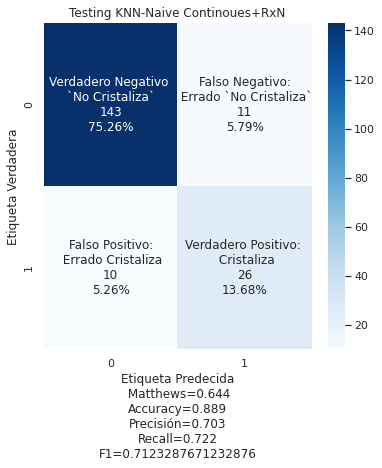

In [37]:
testing_data_confusion_matrix(df_test_full[continous_feat+rxn_feat], clf_naive, "Testing KNN-Naive Continoues+RxN")

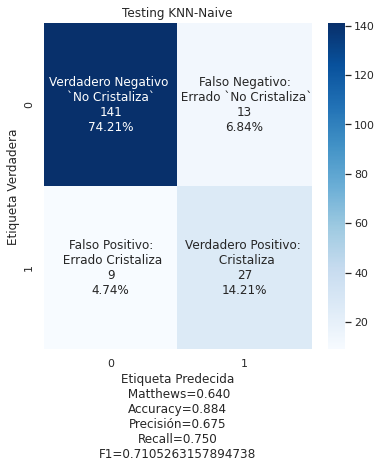

In [27]:
testing_data_confusion_matrix(df_test, clf_naive, "Testing KNN-Naive")

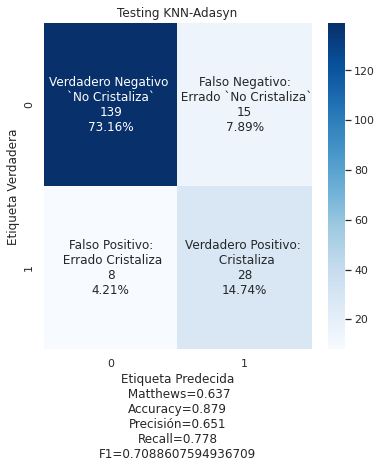

In [391]:
testing_data_confusion_matrix(df_test, clf, "Testing KNN-Adasyn")

In [45]:
param_grid_rf = { 
    'model__max_depth': [3,5,7,10],
    'model__min_samples_leaf': [3,6,9]
}

model = RandomForestClassifier(n_jobs=-1, random_state=1)

clf_rf_asasyn = grid_search_best_model_for(df, model, param_grid_rf, adasyn=True)


In [66]:
pd.DataFrame.from_dict(clf_rf_asasyn.cv_results_).to_csv("rf_adasyn.csv")

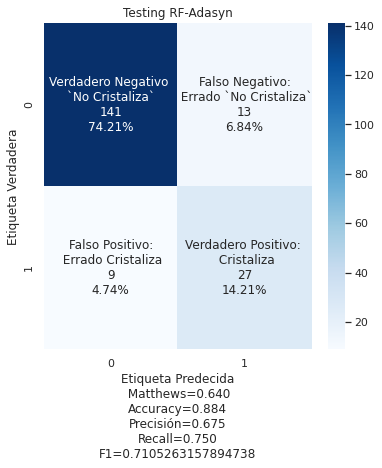

In [46]:
testing_data_confusion_matrix(df_test, clf_rf_asasyn, "Testing RF-Adasyn")


In [50]:
clf_rf_no_asasyn = grid_search_best_model_for(df, model, param_grid_rf)

In [67]:
pd.DataFrame.from_dict(clf_rf_no_asasyn.cv_results_).to_csv("rf_no_adasyn.csv")

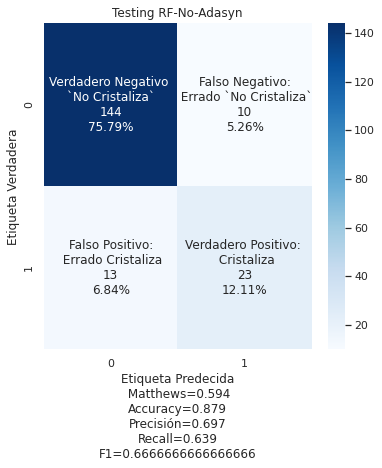

In [52]:
testing_data_confusion_matrix(df_test, clf_rf_no_asasyn, "Testing RF-No-Adasyn")

In [56]:
param_grid_rf_balanced = { 
    'model__max_depth': [3,5,7,10],
    'model__min_samples_leaf': [3,6,9],
    'model__class_weight': ['balanced']
}

model = RandomForestClassifier(n_jobs=-1, random_state=1)

clf_rf_asasyn_balanced = grid_search_best_model_for(df, model, param_grid_rf_balanced, adasyn=True)


In [123]:
clf_rf_asasyn_balanced.best_estimator_

Pipeline(steps=[('std', StandardScaler()),
                ('ada',
                 ADASYN(n_jobs=-1, random_state=42, sampling_strategy=0.4)),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        min_samples_leaf=3, n_jobs=-1,
                                        random_state=1))])

In [125]:
clf_rf_no_asasyn_balanced.best_estimator_

Pipeline(steps=[('std', StandardScaler()),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        min_samples_leaf=3, n_jobs=-1,
                                        random_state=1))])

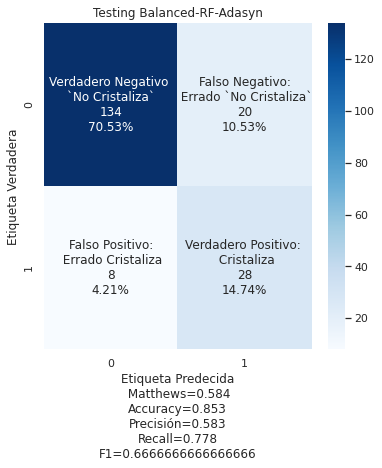

In [58]:
testing_data_confusion_matrix(df_test, clf_rf_asasyn_balanced, "Testing Balanced-RF-Adasyn")

In [59]:
clf_rf_no_asasyn_balanced = grid_search_best_model_for(df, model, param_grid_rf_balanced)

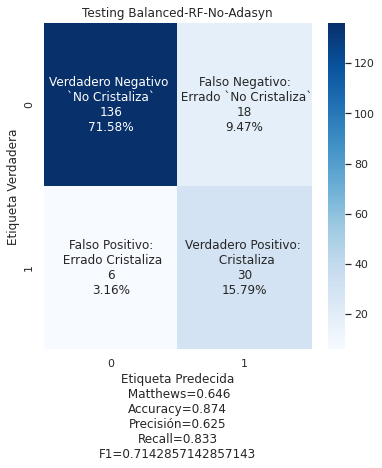

In [62]:
testing_data_confusion_matrix(df_test, clf_rf_no_asasyn_balanced, "Testing Balanced-RF-No-Adasyn")

In [118]:
features_col = rxn_feat+columns_arbitrary_decision
features_col.remove("_out_crystalscore")

def plot_features_importances(features_col, clfs_pipeline, title="Importancia de Atributos"):
    df_features_importances = pd.DataFrame({"features": features_col})
    df_features_importances["importances"] = clfs_pipeline.best_estimator_['model'].feature_importances_
    df_features_importances['features'] = df_features_importances['features'].str.slice(6, 20)
    df_features_importances.sort_values(by="importances", inplace=True, ascending=False)

    plt.figure(figsize=(15,8))
    ax = sns.barplot(x="features", y="importances", data=df_features_importances)    
    ax.set(xlabel='Atributos', ylabel='Importancia (GINI)', ylim=(0, 0.30), title=title)       


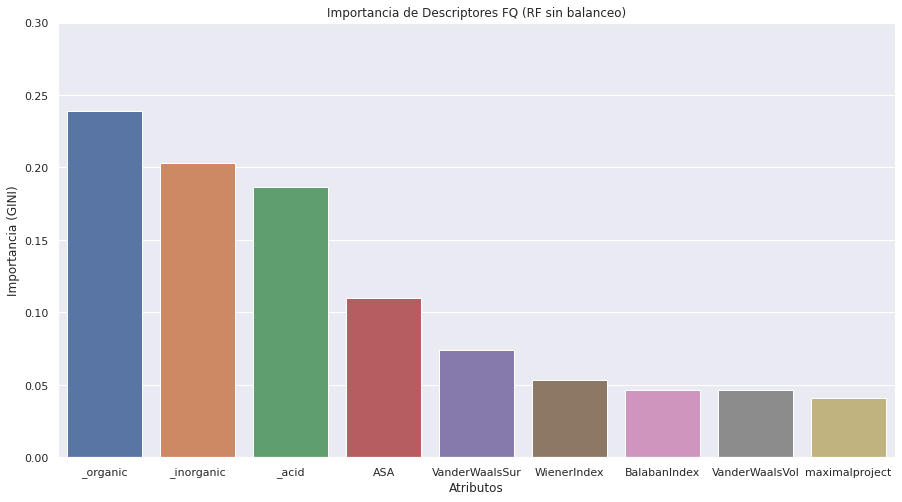

In [126]:
plot_features_importances(features_col, clf_rf_no_asasyn, "Importancia de Descriptores FQ (RF sin balanceo)")

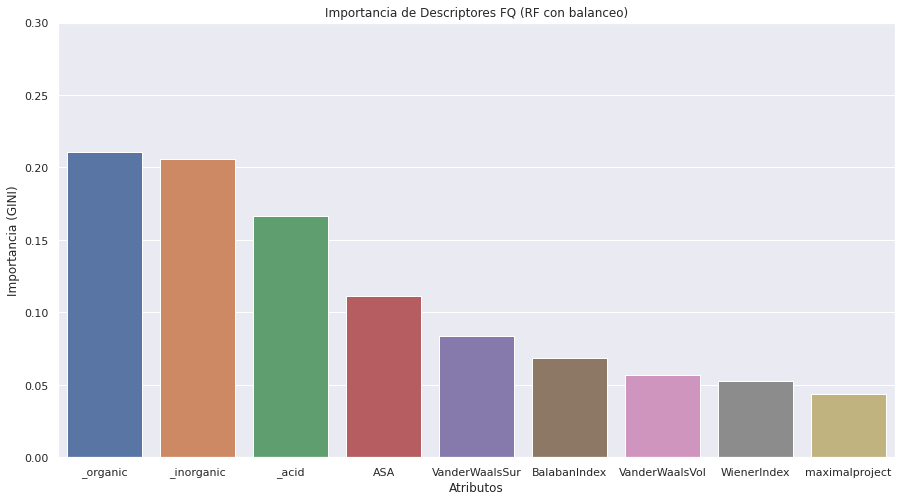

In [127]:
plot_features_importances(features_col, clf_rf_asasyn, "Importancia de Descriptores FQ (RF con balanceo)")  

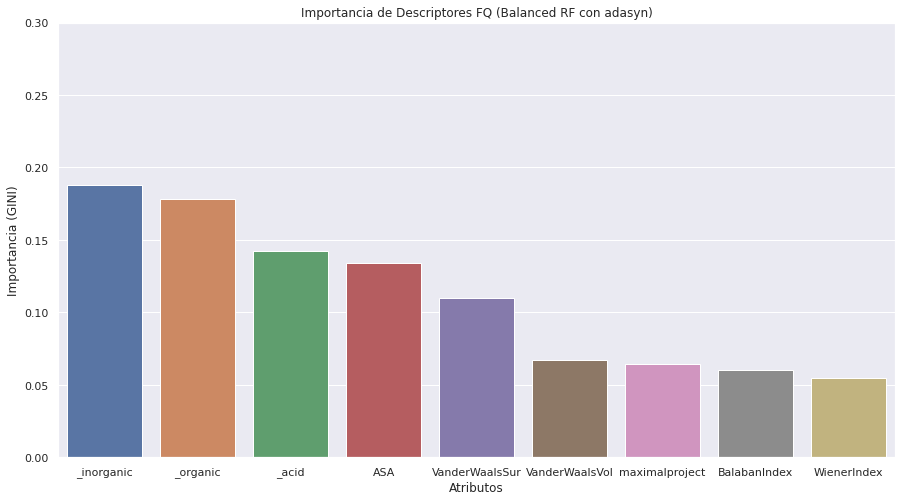

In [128]:
plot_features_importances(features_col, clf_rf_asasyn_balanced, "Importancia de Descriptores FQ (Balanced RF con adasyn)")  


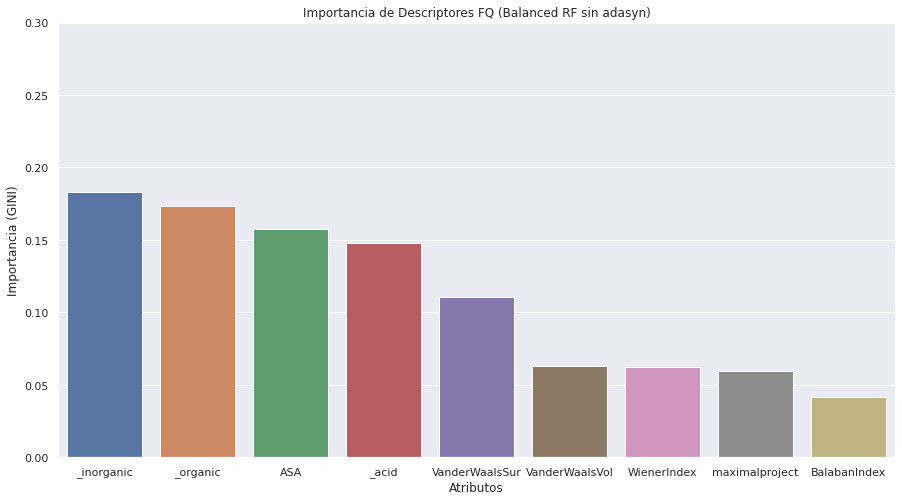

In [129]:
plot_features_importances(features_col, clf_rf_no_asasyn_balanced, "Importancia de Descriptores FQ (Balanced RF sin adasyn)")  


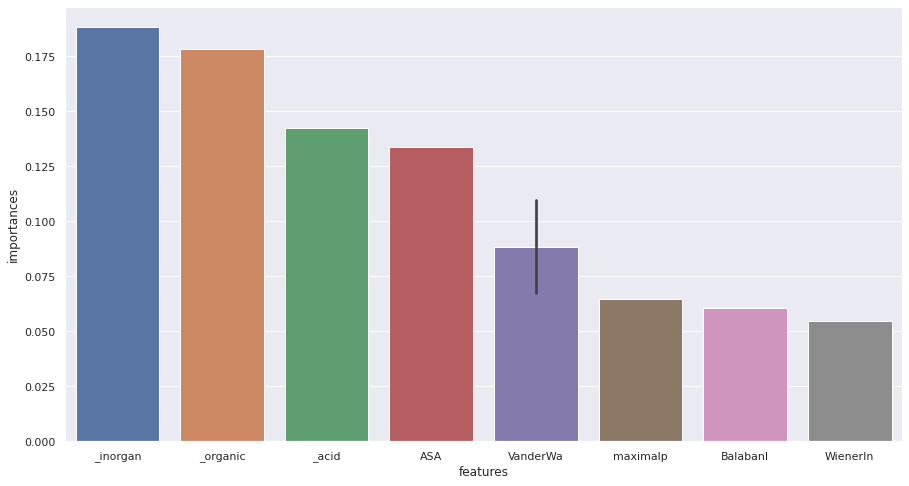

In [107]:
df_features_importances = pd.DataFrame({"features": features_col})
df_features_importances["importances"] = clf_rf_asasyn_balanced.best_estimator_['model'].feature_importances_
df_features_importances['features'] = df_features_importances['features'].str.slice(6, 14)
df_features_importances.sort_values(by="importances", inplace=True, ascending=False)

plt.figure(figsize=(15,8))
ax = sns.barplot(x="features", y="importances", data=df_features_importances)     

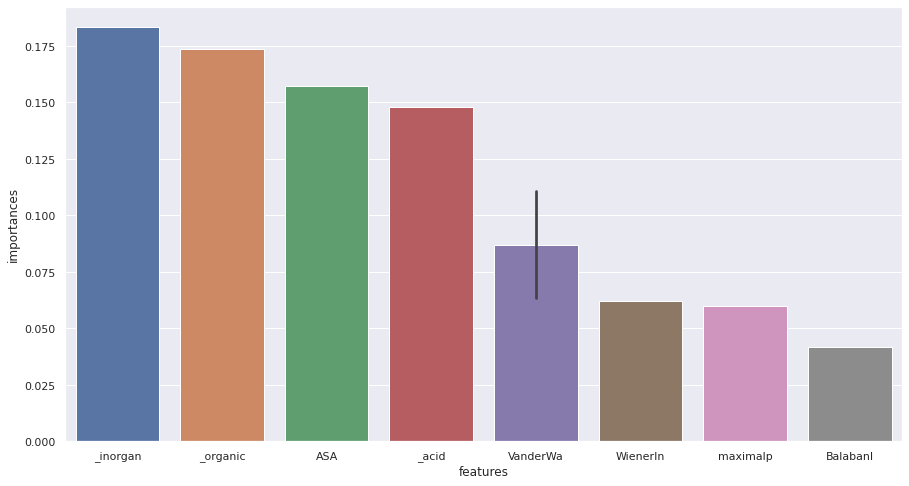

In [108]:
df_features_importances = pd.DataFrame({"features": features_col})
df_features_importances["importances"] = clf_rf_no_asasyn_balanced.best_estimator_['model'].feature_importances_
df_features_importances['features'] = df_features_importances['features'].str.slice(6, 14)
df_features_importances.sort_values(by="importances", inplace=True, ascending=False)

plt.figure(figsize=(15,8))
ax = sns.barplot(x="features", y="importances", data=df_features_importances)     